# Treść zadania

4. „Dobrze byłoby wiedzieć czy dana sesja użytkownika zakończy się zakupem. Dzięki temu nasi konsultanci będą mogli baczniej przyglądać się tym sesjom i szybciej rozwiązywać potencjalne problemy.”

Dane IUM21L_Zad_04_04

# Etap 1


## Problem biznesowy, zadania modelowania, założenia i kryteria sukcesu

„Dobrze byłoby wiedzieć czy dana sesja użytkownika zakończy się zakupem. Dzięki temu nasi konsultanci będą mogli baczniej przyglądać się tym sesjom i szybciej rozwiązywać potencjalne problemy.”

Zadanie biznesowe: oznaczanie sesji jako wartych uwagi w panelu konsultanta.

Biznesowe kryterium sukcesu: zwiększenie szybkości rozwiązywania zgłoszeń przez konsultantów oraz większe zadowolenie klientów mierzone ocenami zakupów.
Zakładamy, że zgłoszenie zajmuje średnio 30min na rozwiązanie. Zatem kryterium sukcesu w tym przypadku to obniżenie tego czasu do 20min. Oczekujemy także poprawienia się średniej oceny klientów o 0.25 (w skali 0-5).

Zadanie modelowania: przygotowanie modelu rekomendacyjnego
na podstawie danych sesji.

Dane do modelowania:
* informacje o sesjach użytkowników zakończonych zakupem
* katalog produktów
* czasy dostawy produktów


## Wczytanie danych do pd.DataFrame

In [14]:
pip install jsonlines pandas numpy

In [15]:
import jsonlines
import pandas as pd
import numpy as np

def read_jsonl(path):
    data = []

    with jsonlines.open(path) as reader:
        for obj in reader:
            data.append(obj)

    return pd.DataFrame(data).convert_dtypes()


In [16]:
users = read_jsonl('./data-original/users.jsonl')
sessions = read_jsonl('./data-original/sessions.jsonl')
deliveries = read_jsonl('./data-original/deliveries.jsonl')
products = read_jsonl('./data-original/products.jsonl')

## Funkcje pomocnicze

In [17]:
def group_and_count(df, cols):
    return df.groupby(cols).size().reset_index(name='count')

def find_duplicates(df, cols):
    res = group_and_count(df, cols)
    return res.loc[res['count'] > 1]

def get_pmf_data(col):
    counts = col.value_counts()
    sum = 0
    for x in counts:
        sum += x
    return counts.map(lambda x: x / sum)

def get_null_count(df, col):
    return df[df[col].isnull()].shape[0]

def get_total_null_count(df):
    return df[df.isnull().any(axis=1)].shape[0]


## Analiza danych, anomalie i ich poprawa

### Użytkownicy

In [18]:
users

,user_id,name,city,street
0,102,Michał Wejman,Kutno,ul. Orzeszkowej 65/78
1,103,Cyprian Bazylewicz,Mielec,ulica Orkana 34
2,104,Dariusz Lesik,Police,al. Wojciecha 62/42
3,105,Fabian Albin,Konin,aleja Brzoskwiniowa 20
4,106,Ada Leszczuk,Gdynia,plac Jaśminowa 93
...,...,...,...,...
195,297,Apolonia Sularz,Gdynia,pl. Wałowa 463
196,298,Andrzej Gąsienica,Warszawa,aleja Bema 837
197,299,Andrzej Leks,Mielec,aleja Urocza 52/54
198,300,Krystyna Szyda,Mielec,aleja Tartaczna 684


Ze względu na małą wielkość tabeli pozwoliliśmy sobie na jej wizualną analizę. Doszliśmy do wniosku, że nie ma w niej brakujących ani odstających wartości.

Na pierwszy rzut oka wygląda, że kolumny `name` i `street` posiadają unikalne wartości dyskretne nominalne.

In [19]:
find_duplicates(users, ['name'])

,name,count


In [20]:
find_duplicates(users, ['street'])

,street,count


Powyższą hipotezę potwierdziły wywołania funkcji `find_duplicates`. Mając na uwadze typ danych, a także ich unikalność, stwierdziliśmy, że kolumny `name` i `street` nie wnoszą same z siebie żadnej informacji. Owszem, te dane będą mogły zostać w jakiś sposób wykorzystane, jak już będziemy mieli gotowy model, ale na etapie samego modelowania są naszym zdaniem bezużyteczne. Niemniej jednak da się z tych kolumn wyciągnąć wartościowe dane.

Na podstawie danych z kolumny `street` moglibyśmy w teorii wyznaczyć przybliżoną lokalizację w postaci długości i szerokości geograficznej, jednak taki proces byłby zbyt kosztowny i relatywnie mało wniósłby do naszego zbioru danych ze względu na fakt posiadania kolumny `city`.

Z kolumny `name` możemy z dużą dokładnością odgadnąć płeć użytkownika kierując się heurystyką, że imiona kobiet kończą się literą *a* (w przeciwieństwie do imion mężczyzn). Zadanie wydaje się dosyć proste, a uzyskana informacja może się okazać dla nas bardzo cenna na późniejszym etapie.

In [21]:
genders = []
for n in users.name:
    first_name = n.split()[0]
    genders.append('F' if first_name[-1] == 'a' else 'M')

users = users.assign(gender=genders)

users

,user_id,name,city,street,gender
0,102,Michał Wejman,Kutno,ul. Orzeszkowej 65/78,M
1,103,Cyprian Bazylewicz,Mielec,ulica Orkana 34,M
2,104,Dariusz Lesik,Police,al. Wojciecha 62/42,M
3,105,Fabian Albin,Konin,aleja Brzoskwiniowa 20,M
4,106,Ada Leszczuk,Gdynia,plac Jaśminowa 93,F
...,...,...,...,...,...
195,297,Apolonia Sularz,Gdynia,pl. Wałowa 463,F
196,298,Andrzej Gąsienica,Warszawa,aleja Bema 837,M
197,299,Andrzej Leks,Mielec,aleja Urocza 52/54,M
198,300,Krystyna Szyda,Mielec,aleja Tartaczna 684,F


Możemy teraz pozbyć się kolumn `name` i `street`, aby nie zaciemniać obrazu. Kolumna `user_id` przyda się przy denormalizacji danych.

In [22]:
users.drop('name', 1, inplace=True)
users.drop('street', 1, inplace=True)

users

,user_id,city,gender
0,102,Kutno,M
1,103,Mielec,M
2,104,Police,M
3,105,Konin,M
4,106,Gdynia,F
...,...,...,...
195,297,Gdynia,F
196,298,Warszawa,M
197,299,Mielec,M
198,300,Mielec,F


Na koniec upewnijmy się, że `user_id` nie zawiera duplikatów, a także wygenerujmy wykresy funkcji masy prawdopodobieństwa dla pozostałych dwóch kolumn.

In [23]:
find_duplicates(users, ['user_id'])

,user_id,count


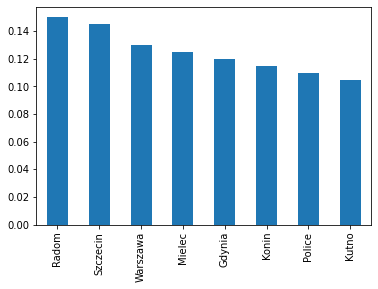

In [24]:
get_pmf_data(users.city).plot(kind='bar')

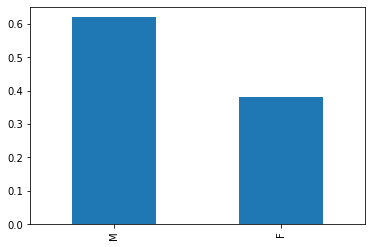

In [25]:
get_pmf_data(users.gender).plot(kind='bar')

### Produkty


In [26]:
products

,product_id,product_name,category_path,price
0,1001,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58970000.00
1,1002,Kyocera FS-1135MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,2048.50
2,1003,Kyocera FS-3640MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,7639.00
3,1004,Fallout 3 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
4,1005,Szalone Króliki Na żywo i w kolorze (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
...,...,...,...,...
314,1315,Jabra Talk,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,54.99
315,1316,Plantronics Voyager Legend,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,249.00
316,1317,Plantronics Savi W740,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,1303.96
317,1318,Plantronics Savi W710,Sprzęt RTV;Audio;Słuchawki,553.00


Podobnie jak w przypadku tabeli z użytkownikami, tą tabelę także przeanalizowaliśmy wizualnie i nie zauważyliśmy brakujących danych. Znaleźliśmy natomiast 3 problemy:
1. produkt o id == 1076 posiada bardzo długą nazwę, w której nazwa produktu stanowi tylko jej pierwszą część,
2. niektóre produkty posiadają ujemne ceny
3. niektóre produkty posiadają ceny *z kosmosu*

#### Ujemne ceny produktów

In [27]:
products[products.price < 0].head(8)

,product_id,product_name,category_path,price
19,1020,Dead Space 2 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,-89.00
23,1024,Mortal Kombat (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,-89.99
43,1044,Assassin&#39;s Creed 3 (PS3),Gry i konsole;Gry na konsole;Gry PlayStation3,-79.90
44,1045,Call of Duty Modern Warfare 2 (PS3),Gry i konsole;Gry na konsole;Gry PlayStation3,-59.90
48,1049,Max Payne 3 (PC),Gry i konsole;Gry komputerowe,-17.90
49,1050,Bioshock 2 (PC),Gry i konsole;Gry komputerowe,-37.90
58,1059,Auta 2 (PC),Gry i konsole;Gry komputerowe,-22.90
63,1064,LCD BenQ GL2250HM,Komputery;Monitory;Monitory LCD,-380.90


Od razu jednak zauważyliśmy, że wartości bezwględne z powyższych cen dają prawidłowe ceny. Naprawiamy problem stosując funkcję **abs()**.

In [28]:
products.price = products.price.abs()

#### Ceny *z kosmosu*

In [29]:
PRICE_THRESHOLD = 100000
products[products.price > PRICE_THRESHOLD].head(8)

,product_id,product_name,category_path,price
0,1001,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58970000.0
8,1009,Kinect Joy Ride (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,69000000.0
35,1036,LCD Asus VK228H,Komputery;Monitory;Monitory LCD,639000000.0
42,1043,Fight Night Champion (PS3),Gry i konsole;Gry na konsole;Gry PlayStation3,109000000.0
72,1073,Jabra Drive,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,129000000.0
140,1141,Król Futbolu Piłkarski Quiz (PC),Gry i konsole;Gry komputerowe,1000000.0
142,1143,GTR Evolution (PC),Gry i konsole;Gry komputerowe,25490000.0
153,1154,Civilization 4 (PC),Gry i konsole;Gry komputerowe,40900000.0


Początkowo planowaliśmy znaleźć średnią cenę produktu w każdej kategorii (wykluczając produkty z nierelanie wysokimi cenami) i przypisać znalezione wartości produktom z błędnymi cenami, jednak po dokładniejszym przypatrzeniu się błędnym wartościom zauważyliśmy, że wystarczy podzielić je przez 10^6, aby uzyskać prawidłowe ceny.

In [30]:
for i, p in products.iterrows():
    price = p.price
    if price > PRICE_THRESHOLD:
        price /= 10**6
        products.at[i, 'price'] = price

#### Nazwy produktów

Sytuacja analogiczna do kolumn `name` i `street` z tabeli z użytkownikami. Po upewnieniu się, że `product_name` nie zawiera duplikatów, możemy pozbyć się tej kolumny, ponieważ nie jesteśmy w stanie wyciągnąć z niej żadnej informacji. Nie przejmujemy się także pojedynczym produktem ze zbyt długą nazwą, ponieważ mimo tego zawiera on na początku właściwą nazwę produktu.

In [31]:
find_duplicates(products, ['product_name'])

,product_name,count


In [32]:
products.drop('product_name', 1, inplace=True)

#### Rozkłady cen i kategorii

Zacznijmy od wygenerowania rozkładu cen.

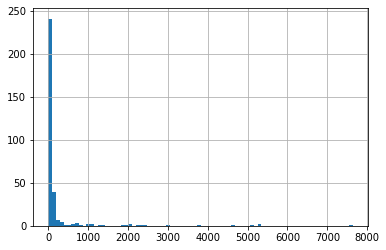

In [33]:
products.price.hist(bins = 80)

Nie wygląda to dobrze, ale trochę przypomina rozkład normalny logarytmiczny. Spróbujmy zlogarytmować ceny i wygenerować kolejny rozkład.

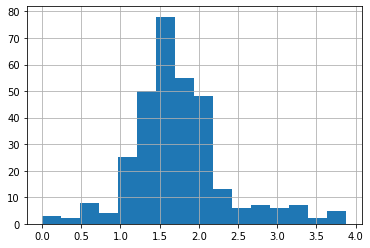

In [34]:
products['price_log'] = np.log10(products.price)
products.price_log.hist(bins = 16)

Ze względu na "grube ogony" rozkład przypomina swoją postacią rozkład Cauchyego.

Zobaczmy, co dostaniemy generując wykresy funkcji masy prawdopodobieństwa dla ścieżek kategorii.

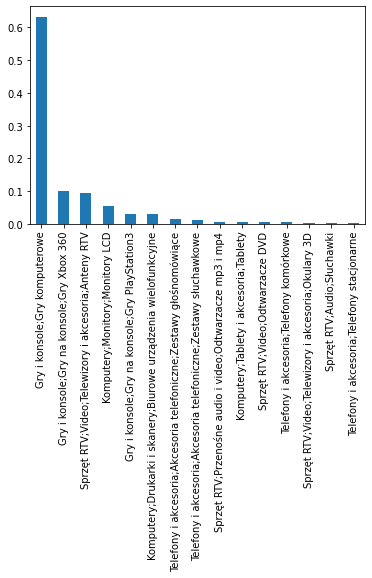

In [35]:
get_pmf_data(products.category_path).plot(kind='bar')

Ponieważ kategorie są wartościami dyskretnymi, nie możemy ich zlogarytmować. Na wykresie powyżej wyraźnie widać, że kategorie znacząco różnią się liczbą produktów, które się w nich znajdują. Całe szczęście możemy spróbować wyciągnąć tylko pierwszą kategorię ze ścieżki. Być może pogrupowanie produktów w ten sposób przyniesie bardziej zrównoważone wyniki.

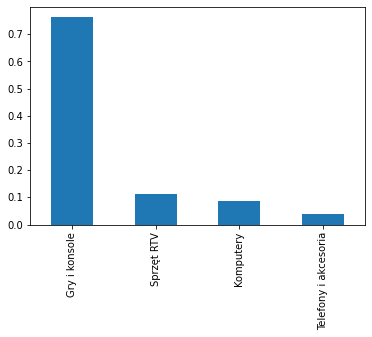

In [36]:
cat_1 = []
for c in products.category_path:
    path = c.split(';')
    cat_1.append(path[0])

get_pmf_data(pd.Series(cat_1)).plot(kind='bar')

Niestety za wiele to nie pomogło. Kategorie w dalszym ciągu są bardzo niezbalansowane. Wpłynie to negatywnie na jakość naszego modelu, chyba że uda nam się uzyskać dostęp do bardziej rozbudowanego zbioru danych.

### Dostawy

In [37]:
deliveries

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company
0,20001,2021-02-05T08:33:28,2021-02-08T08:37:06,360
1,20002,2021-03-07T12:23:15,2021-03-11T12:26:35,516
2,20003,2021-01-02T15:20:11,2021-01-06T15:20:31,516
3,20004,2021-02-11T19:37:19,2021-02-16T19:40:13,360
4,20005,2021-03-05T17:08:07,2021-03-10T17:12:38,<NA>
...,...,...,...,...
4952,24953,2021-02-18T10:43:51,2021-02-22T10:47:16,360
4953,24954,2021-03-07T15:09:09,2021-03-12T15:14:03,516
4954,24955,2021-02-14T10:34:07,2021-02-18T10:36:04,620
4955,24956,2021-02-05T13:31:10,2021-02-08T13:32:00,620


In [38]:
get_null_count(deliveries, 'purchase_timestamp')

0

In [39]:
get_null_count(deliveries, 'delivery_timestamp')

238

In [40]:
get_null_count(deliveries, 'delivery_company')

247

In [41]:
get_total_null_count(deliveries)

473

Prawie 10% rekordów posiada brakujące wartości w kolumnie `delivery_timestamp` lub `delivery_company`.

In [42]:
deliveries[deliveries.purchase_timestamp >= deliveries.delivery_timestamp].shape[0]

0

Całe szczęście przynajmniej daty są na pierwszy rzut oka poprawne, tj. czas dostarczenia jest zawsze późniejszy od czasu zakupu.

Zauważyliśmy jednak, że tabela z sesjami również posiada kolumnę `timestamp`. Logiczne by zatem było, aby wartości w kolumnie `timestamp` w tabeli z sesjami pokrywały się z odpowiadającymi wartościami w kolumnie `purchase_timestamp` w tabeli z dostawami, jeśli `event_type == BUY_PRODUCT`. Sprawdźmy to!

In [43]:
del_ses = sessions.merge(deliveries, how='left', on='purchase_id')
del_ses_buy = del_ses[(del_ses.event_type == 'BUY_PRODUCT') & (del_ses.timestamp == del_ses.purchase_timestamp)]
del_ses_buy[['session_id', 'timestamp', 'purchase_timestamp']]

,session_id,timestamp,purchase_timestamp
2,100001,2021-02-05T08:33:28,2021-02-05T08:33:28
7,100003,2021-03-07T12:23:15,2021-03-07T12:23:15
18,100006,2021-01-02T15:20:11,2021-01-02T15:20:11
21,100007,2021-02-11T19:37:19,2021-02-11T19:37:19
27,100010,2021-03-05T17:08:07,2021-03-05T17:08:07
...,...,...,...
35553,109829,2021-02-18T10:43:51,2021-02-18T10:43:51
35559,109832,2021-03-07T15:09:09,2021-03-07T15:09:09
35570,109836,2021-02-14T10:34:07,2021-02-14T10:34:07
35572,109837,2021-02-05T13:31:10,2021-02-05T13:31:10


Liczba otrzymanych rekordów jest równa liczbie rekordów w tabeli z dostawami, co oznacza, że nasza hipoteza została potwierdzona! To oznacza, że kolumna `purchase_timestamp` będzie mogła zostać usunięta po zdenormalizowaniu danych, ponieważ nie wnosi żadnych nowych informacji, które nie są zawarte w kolumnie `timestamp` tabeli z sesjami.

Ciągle pozostaje kwestia brakujących danych w kolumnach `delivery_timestamp` lub `delivery_company`. Sama kolumna `delivery_timestamp` nie wnosi informacji, które byłyby przydatne w naszym problemie. Można jednak na jej podstawie i z pomocą kolumny `purchase_timestamp` wyznaczyć, jak długo zajęło wysłanie i dostarczenie paczki. Niestety w dalszym ciągu nie będzie to informacja, która będzie miała znaczenie dla naszego problemu. Podobnie jest z kolumną `delivery_company`. Nasz problem polega na przewidywaniu, czy dana sesja użytkownika zakończy się zakupem. Cała tabela z dostawami zawiera informacje, które są uzupełniane dopiero po dokonaniu zakupu, a zatem nie wpływają na decyzję zakupu, ponieważ nie są znane w momencie jej podejmowania. Czysto teoretycznie można by postawić hipotezę: *jeśli dostarczenie ostatniej paczki klienta zajęło dłużej niż 7 dni, to istnieje duża szansa, że ta osoba nic już u nas nie kupi*. Jednak jeśli dana osoba miałaby u nas już nigdy nic nie kupić, to raczej istnieje też duże prawdopodobieństwo, że ktoś taki przestanie całkowicie korzystać ze strony naszego sklepu, a zatem nie pojawią się sesje, gdzie będziemy mogli na podstawie takiego modelu stwierdzić, że nie dojdzie do zakupu.

Podsumowując, ze względu na relatywnie duży odsetek wybrakowanych danych, a także bardzo małą ilość informacji, które można z nich uzyskać, które byłyby istotne dla naszego problemu, podjęliśmy decyzję o całkowitym odrzuceniu tabeli z dostawami.

### Sesje

In [44]:
sessions

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
0,100001,2021-02-05T08:25:04,102,1035,VIEW_PRODUCT,5,<NA>
1,100001,2021-02-05T08:29:54,102,1067,VIEW_PRODUCT,5,<NA>
2,100001,2021-02-05T08:33:28,102,1067,BUY_PRODUCT,5,20001
3,100002,2021-02-27T05:58:42,102,1201,VIEW_PRODUCT,0,<NA>
4,100002,2021-02-27T06:02:00,102,1074,VIEW_PRODUCT,0,<NA>
...,...,...,...,...,...,...,...
35574,109838,2021-01-29T01:08:33,301,1044,VIEW_PRODUCT,0,<NA>
35575,109838,2021-01-29T01:09:27,301,1084,VIEW_PRODUCT,0,<NA>
35576,109838,2021-01-29T01:10:23,301,1041,VIEW_PRODUCT,0,<NA>
35577,109838,2021-01-29T01:14:41,301,1046,VIEW_PRODUCT,0,<NA>


Mając na uwadze nasze postanowienie o całkowitym odrzuceniu tabeli z dostawami możemy się pozbyć kolumny `purchase_id`.

In [45]:
sessions.drop('purchase_id', 1, inplace=True)

In [46]:
get_null_count(sessions, 'timestamp')

0

In [47]:
get_null_count(sessions, 'user_id')

1788

In [48]:
get_null_count(sessions, 'product_id')

1741

In [49]:
get_null_count(sessions, 'event_type')

0

In [50]:
get_null_count(sessions, 'offered_discount')

0

In [51]:
get_total_null_count(sessions)

3440

Jak widać, tylko kolumny `user_id` oraz `product_id` posiadają brakujące dane. Zauważyliśmy jednak, że pojedyncza sesja może posiadać kilka wpisów. Wiemy także, że jedna sesja dotyczy zawsze tylko jednego użytkownika (a przynajmniej się tego domyślamy, ale to także przy okazji sprawdzimy). Możemy w takim razie uzupełnić brakujące dane w kolumnie `user_id` poprzez sprawdzenie, jaka wartość znajduje się w innych wierszach dotyczących tej samej sesji (posiadający tą samą wartość `session_id`).

In [52]:
for i, s in sessions[sessions.user_id.isnull()].iterrows():
    rec_id = -1
    for j, r in sessions[sessions.session_id == s.session_id].iterrows():
        if not pd.isnull(r.user_id):
            if rec_id == -1 or rec_id == r.user_id:
                rec_id = r.user_id
            else: 
                raise Exception("Two distinct users in one session")
    if rec_id != -1:
        sessions.at[i, 'user_id'] = rec_id

get_null_count(sessions, 'user_id')

120

In [53]:
sessions[sessions.user_id.isnull()].session_id.nunique()

107

In [54]:
sessions.session_id.nunique()

9838

Niestety w dalszym ciągu nie udało nam się pozbyć brakujących wartości w kolumnie `user_id`. Całe szczęście sesje, które nie posiadają ani jednej wartości we wspomnianej kolumnie stanowią mniej niż 1.1% wszystkich sesji, a zatem nic nie stoi na przeszkodzie, aby całkowicie je usunąć z naszego zbioru.

In [55]:
sessions.drop(sessions[sessions.user_id.isnull()].index, inplace=True)

In [56]:
sessions[sessions.product_id.isnull()].session_id.nunique()

1550

Nie zmienia to jednak faktu, że w dalszym ciągu prawie 16% sesji posiada co najmniej jedną brakującą wartość w kolumnie `product_id`, której nie można w podobny sposób odzyskać. Nie możemy się pozbyć całej kolumny, ponieważ jest kluczowa dla naszego problemu. Jeśli nie otrzymamy lepszych danych, będziemy zmuszeni pozbyć się wszystkich sesji, którym brakuje co najmniej jednej wartości w kolumnie `product_id`. Nie możemy usunąć pojedynczych wpisów z brakującymi wartościami, ponieważ spowoduje to *zmodyfikowanie sesji*, a taka sytuacja prawdopodobnie o wiele bardziej odbije się na jakości naszego modelu niż usunięcie całych sesji.

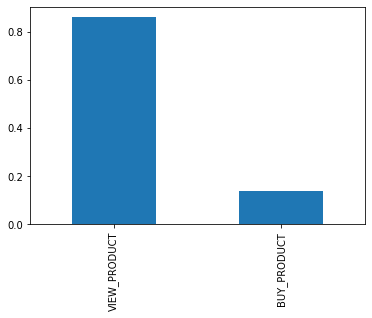

In [57]:
get_pmf_data(sessions.event_type).plot(kind='bar')

In [58]:
success = 0
fail = 0
visited = []
for i, s in sessions.iterrows():
    buy = False
    if s.session_id not in visited:
        visited.append(s.session_id)
        for j, r in sessions[sessions.session_id == s.session_id].iterrows():
            if r.event_type == 'BUY_PRODUCT':
                buy = True
        if buy:
            success += 1
        else:
            fail += 1


Success: 4951
Fail: 4780


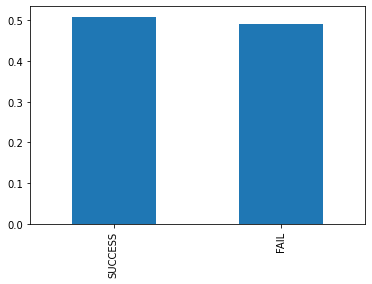

In [59]:
print(f'Success: {success}')
print(f'Fail: {fail}')
all = success + fail
pd.Series({"SUCCESS": success/all, "FAIL": fail/all}).plot(kind='bar')

Z powyższego wykresu wynika, że mniej więcej równo połowa sesji zakończyła się zakupem. Jest to bardzo dobra wiadomość, ponieważ nie będziemy musieli stosować under/oversamplingu.

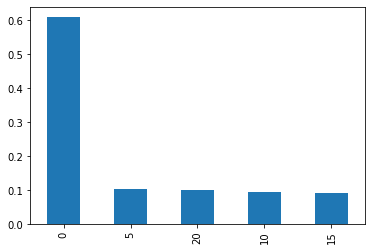

In [60]:
get_pmf_data(sessions.offered_discount).plot(kind='bar')

In [61]:
sessions.timestamp = pd.to_datetime(sessions.timestamp)
sessions['hour'] = sessions.timestamp.dt.hour
sessions['weekday'] = sessions.timestamp.dt.day_name()

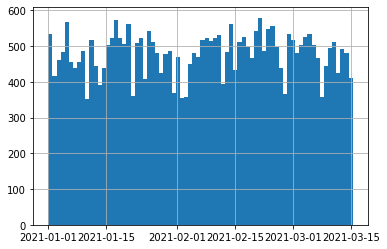

In [62]:
sessions.timestamp.hist(bins=74)

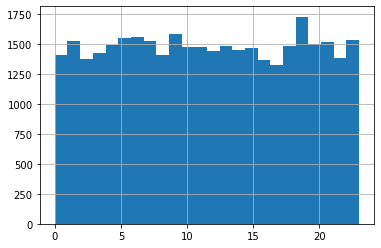

In [63]:
sessions.hour.hist(bins=24)

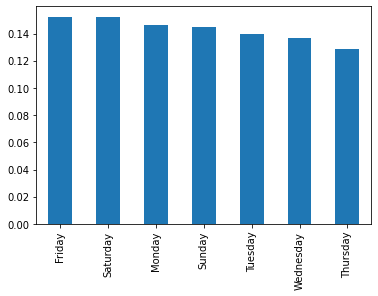

In [64]:
get_pmf_data(sessions.weekday).plot(kind='bar')

## Denormalizacja



In [65]:
data = sessions.merge(users, how='left', on='user_id').merge(products, how='left', on='product_id')

In [66]:
data

,session_id,timestamp,user_id,product_id,event_type,offered_discount,hour,weekday,city,gender,category_path,price,price_log
0,100001,2021-02-05 08:25:04,102,1035,VIEW_PRODUCT,5,8,Friday,Kutno,M,Telefony i akcesoria;Telefony komórkowe,2199.90,3.342403
1,100001,2021-02-05 08:29:54,102,1067,VIEW_PRODUCT,5,8,Friday,Kutno,M,Telefony i akcesoria;Telefony komórkowe,207.33,2.316662
2,100001,2021-02-05 08:33:28,102,1067,BUY_PRODUCT,5,8,Friday,Kutno,M,Telefony i akcesoria;Telefony komórkowe,207.33,2.316662
3,100002,2021-02-27 05:58:42,102,1201,VIEW_PRODUCT,0,5,Saturday,Kutno,M,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,327.47,2.515172
4,100002,2021-02-27 06:02:00,102,1074,VIEW_PRODUCT,0,6,Saturday,Kutno,M,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,86.28,1.935910
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35454,109838,2021-01-29 01:08:33,301,1044,VIEW_PRODUCT,0,1,Friday,Gdynia,M,Gry i konsole;Gry na konsole;Gry PlayStation3,79.90,1.902547
35455,109838,2021-01-29 01:09:27,301,1084,VIEW_PRODUCT,0,1,Friday,Gdynia,M,Gry i konsole;Gry na konsole;Gry PlayStation3,99.99,1.999957
35456,109838,2021-01-29 01:10:23,301,1041,VIEW_PRODUCT,0,1,Friday,Gdynia,M,Gry i konsole;Gry na konsole;Gry PlayStation3,79.90,1.902547
35457,109838,2021-01-29 01:14:41,301,1046,VIEW_PRODUCT,0,1,Friday,Gdynia,M,Gry i konsole;Gry na konsole;Gry PlayStation3,61.18,1.786609
